In [5]:
import os
import mnist
import numpy as np
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from matplotlib import cm

In [8]:
def load_mcs(is_gss=False):
    # <gss> 0:circle, 1:rectangle, 2:triangle
    # <mc> 0:B, 1:G, 2:R
    # <mcs> 0~2:mc, 3~5:gss
    shapes = ['circle', 'rectangle', 'triangle']
    images = []
    labels = []

    for i in tqdm(range(len(shapes))):
        s = shapes[i]
        path = 'MultiColor-Shapes-Database/shapes/'+s
        files = os.listdir(path=path)
        files.sort()
        for f in tqdm(files, leave=False):
            fpath = path +'/'+f
            if is_gss:
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                #img = 255-img
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.imread(fpath)

            arr = np.ravel(img/255.0).astype(np.float32)

            if 'blue' in f: j = 0
            elif 'green' in f: j = 1
            else: j = 2 # red

            #index = i * 3 + j

            images.append(arr)
            if is_gss: labels.append(i)
            else: labels.append([j,i+3])
            
    labels = np.array(labels)
    images = np.array(images)
    return images, labels

100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Text(0.5, 1.0, '2')

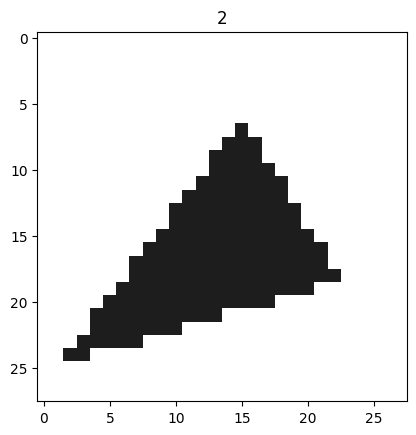

In [9]:
images, labels = load_mcs(is_gss=True)
idx = np.random.randint(0,4500)
plt.imshow(cv2.cvtColor(images[idx].reshape(28,28,3), cv2.COLOR_BGR2RGB))
plt.title(str(labels[idx]))
#np.savez_compressed('dataset/Grayscale-Shapes-Dataset.npz', image=images, label=labels)

In [10]:
def load_mnist():
    z = mnist.train_images()
    data = []
    for i in range(z.shape[0]):
        arr = 255-z[i] #bitwise not
        #arr = z[i]
        arr = cv2.cvtColor(arr,cv2.COLOR_GRAY2RGB)
        arr = np.ravel(arr/255.0).astype(np.float32)
        data.append(arr)

    return np.array(data), mnist.train_labels()

[1. 1. 1. ... 1. 1. 1.] (60000, 2352)


Text(0.5, 1.0, '9')

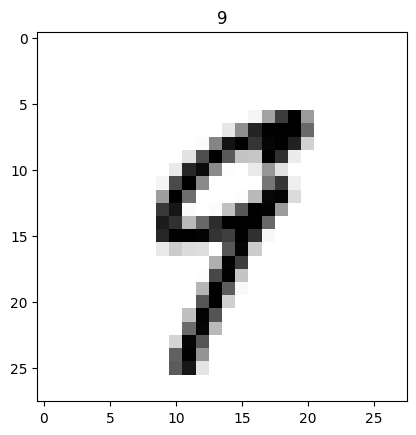

In [11]:
images, labels = load_mnist()
print(images[0], images.shape)
idx = np.random.randint(0,labels.shape[0])
plt.imshow(cv2.cvtColor(images[idx].reshape(28,28,3), cv2.COLOR_BGR2RGB))
plt.title(str(labels[idx]))

In [12]:
np.savez_compressed('dataset/Mnist2352.npz', image=images, label=labels)

In [86]:
def colorize(img, j):
  #j = np.random.randint(0,3)
  #cname = None

  if j == 0:
    colorized = cm.Blues(img)
    #cname = 'Blue'
  elif j == 1:
    colorized = cm.Greens(img)
    #cname = 'Green'
  else:
    colorized = cm.Reds(img)
    #cname = 'Red'
  #plt.imshow(colorized)
  #plt.title(cname)
  #plt.show()
  colorized = colorized[:,:,[2,1,0]] #RGB => BGR
  colorized = np.ravel(colorized).astype(np.float32)

  return colorized #, j, cname

In [104]:
def colored_mnist():
  # <mcs> 0~2:mc, 3~12:gss
  #L_out = list(itertools.chain.from_iterable([['Blue_'+str(x), 'Green_'+str(x), 'Red_'+str(x)] for x in list(range(10))]))
  ''' 
  28x28 COLORED mnist digits
  '''  
  import mnist
  z = mnist.train_images()
  index = mnist.train_labels()
  data = []
  label = []
  for i in tqdm(range(z.shape[0])):
    data += [colorize(z[i], x) for x in range(3)]
    #label += [index[i]*3+x for x in range(3)]
    label += [[x,3+index[i]] for x in range(3)]

  return np.array(data), np.array(label)

In [107]:
images, labels = colored_mnist()
print(images[0],labels.shape[0])

100%|██████████| 60000/60000 [00:11<00:00, 5304.24it/s]


[1.         0.9843137  0.96862745 ... 1.         0.9843137  0.96862745] 180000


Text(0.5, 1.0, '[2 3]')

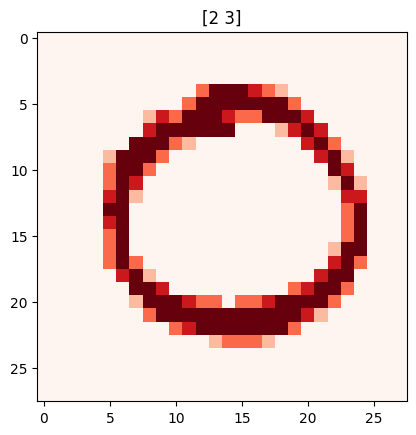

In [109]:
idx = np.random.randint(0,labels.shape[0])
plt.imshow(cv2.cvtColor(images[idx].reshape(28,28,3), cv2.COLOR_BGR2RGB))
plt.title(str(labels[idx]))

In [110]:
np.savez_compressed('dataset/Colored-Mnist.npz', image=images, label=labels)

In [54]:
def permeabilize(img):
    if img.shape[2]==3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    img[..., 3] = np.where(np.all(img == 255, axis=-1), 0, 255)
    return img

In [55]:
def imgmix_nonalpha(back, fore):
    orig2 = cv2.cvtColor(fore,cv2.COLOR_GRAY2BGR)
    img2gray = fore
    _, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    img2gray_src = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2RGB)
    #plt.imshow(img2gray_src)
    #plt.show()

    img1_bg = cv2.bitwise_and(back,back,mask = mask_inv)
    #plt.imshow(img1_bg)
    #plt.show()

In [5]:
def transparent(img):
    alpha = img
    img = cv2.bitwise_not(img)
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    img[:,:,3] = alpha
    return img.astype(np.uint8)

In [6]:
def imgmix_alpha(back, fore):
    from PIL import Image
    back = cv2.cvtColor(255*back.astype(np.float32), cv2.COLOR_BGR2RGB)
    back = Image.fromarray(back.astype(np.uint8)).convert('RGBA')

    fore = transparent(fore)
    fore = Image.fromarray(cv2.cvtColor(fore, cv2.COLOR_BGRA2RGBA)).convert('RGBA')

    blended = Image.alpha_composite(back, fore)
    #blended.show()
    blended = cv2.cvtColor(np.asarray(blended), cv2.COLOR_RGBA2BGR)
    return blended

In [7]:
def shape_mnist():
    import mnist
    z = mnist.train_images()
    index = mnist.train_labels()
    mcs = np.load('Multicolor-Shapes-Database.npz', allow_pickle=True)
    image = []
    label = []
    
    for num in range(10):
        index_digit = np.random.choice(np.where(index==num)[0], size=10)
        for shape in range(9):
            index_shape = np.random.choice(np.where(mcs['label']==shape)[0], size=10)
            for i in index_digit:
                digit = z[i]
                for j in index_shape:
                    img = mcs['image'][j,:].reshape((28,28,3))
                    blended = imgmix_alpha(img, digit)
                    blended = blended.astype(float)/255.0
                    image.append(blended.flatten())
                    label.append(shape*10+num)
    return np.array(image), np.array(label)

In [8]:
images, labels = shape_mnist()
print(images.shape, labels.shape)
np.savez_compressed('MCS-Mnist', image=images, label=labels)

(9000, 2352) (9000,)


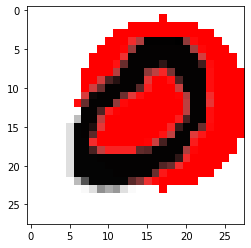

In [3]:
arr = np.load('MCS-Mnist.npz')
plt.imshow(arr['image'][0].reshape(28,28,3))